# This was the notebook I did most of the dev work in, using DNABERT2 as my toy model for getting LRP up and running.
## Hence, there are a few remnants of my debugging and verification work further down in this notebook

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from transformers import AutoModel, AutoTokenizer
import torch
import time

In [3]:
import os
import sys
module_path = os.path.join(os.getcwd(), '..')
sys.path.append(module_path)

In [4]:
from lrp_engine import LRPEngine, checkpoint_hook

In [5]:
model_name = "zhihan1996/DNABERT-2-117M"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModel.from_pretrained(model_name, trust_remote_code=True)

C:\Users\Kevin\.cache\huggingface\modules\transformers_modules\zhihan1996\DNABERT-2-117M\7bce263b15377fc15361f52cfab88f8b586abda0\bert_layers.py:126: UserWarning: Unable to import Triton; defaulting MosaicBERT attention implementation to pytorch (this will reduce throughput when using this model).
  warnings.warn(
Some weights of BertModel were not initialized from the model checkpoint at zhihan1996/DNABERT-2-117M and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(4096, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertUnpadAttention(
          (self): BertUnpadSelfAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (Wqkv): Linear(in_features=768, out_features=2304, bias=True)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (mlp): BertGatedLinearUnitMLP(
          (gated_layers): Linear(in_features=768, out_features=6144, bias=False)
          (act): GELU(approximate='none')
          (wo): L

In [7]:
for layer_module in model.encoder.layer:
    layer_module.attention.self.register_forward_hook(checkpoint_hook)

In [8]:
torch.autograd.set_detect_anomaly(True)

In [9]:
dna = "ACGTAGCATCGGATCTATCTATCGACACTTGGTTATCGATCTACGAGCATCTCGTTAGCGGGATTAGAGTAG"
inputs = tokenizer(dna, return_tensors = 'pt')["input_ids"]
hidden_states : torch.Tensor = model(inputs.to(device), requires_grad=True)[1] # [1, sequence_length, 768]

In [10]:
lrp_engine = LRPEngine(with_grad=True, use_bilinear_mm=True)

In [11]:
lrp_output = lrp_engine.run(hidden_states)

In [12]:
lrp_output

([tensor([[ 1.7368e-10, -1.5660e-11,  5.7511e-10,  ..., -2.4811e-10,
           -1.8239e-11, -6.0788e-11],
          [-5.8351e-09, -6.0598e-10,  1.1038e-08,  ..., -2.5992e-09,
            7.9350e-10,  9.9687e-10],
          [ 2.5888e-09, -1.3351e-09,  7.7895e-09,  ...,  3.1683e-08,
           -9.6506e-10, -1.5362e-08],
          ...,
          [ 6.2376e-10, -6.5749e-09,  1.7158e-09,  ..., -1.2786e-09,
           -9.9034e-10, -8.2732e-10],
          [-1.0457e-10, -5.6145e-10,  2.1068e-10,  ..., -3.9289e-10,
            4.5256e-10,  7.5898e-11],
          [ 1.7427e-12,  1.2504e-10, -9.1040e-11,  ..., -2.9582e-12,
            1.7817e-11, -1.2256e-11]], grad_fn=<AddBackward0>),
  tensor([[-4.8186e-10, -2.0942e-10, -1.6248e-09,  ...,  9.5019e-09,
           -3.2604e-09, -8.8398e-10],
          [ 3.5090e-08,  2.1071e-09,  5.7561e-09,  ..., -2.9619e-09,
           -4.7950e-09,  1.0508e-09],
          [ 1.1296e-08, -1.2244e-07,  1.2464e-08,  ..., -1.8841e-08,
            1.3173e-09,  8.6544e-0

In [13]:
lrp_output[0][-1].mean(dim=-1).sum().backward(retain_graph=True)

In [16]:
for name, p in model.named_parameters():
    if p.grad.isnan().any():
        print(p.grad)

In [12]:
from lrp_engine.lrp_graph import make_graph

In [13]:
g1 = make_graph(hidden_states)
ac1 = [ ac.variable for ac in list(filter(lambda f: type(f).__name__ == "AccumulateGrad", list(g1[0].keys()))) ]

In [14]:
g = make_graph(lrp_output[0][0])

In [15]:
ac2 = [ ac.variable for ac in list(filter(lambda f: type(f).__name__ == "AccumulateGrad", list(g[0].keys()))) ]

In [16]:
diff = list(set(ac1).difference(set(ac2)))

In [19]:
for name, p in model.named_parameters():
    if all(not (ac is p) for ac in ac1):
        print(name)

In [10]:
checkpoint_vals, param_node_vals = lrp_engine.run(hidden_states.half())

<ToCopyBackward0 object at 0x28ecaec10> 888 [887]
<ViewBackward0 object at 0x28ecae340> 887 [886]
<torch.autograd.function.IndexPutFirstAxisBackward object at 0x2928fd340> 886 [885]
<NativeLayerNormBackward0 object at 0x28ecbad90> 885 [882, 883, 884]
'topo_ind'


ValueError: too many values to unpack (expected 2)

In [11]:
checkpoint_vals1, param_node_vals1 = lrp_engine.run(hidden_states.half())

In [12]:
promises = list(lrp_engine.promise_bucket.start_nodes_to_promise.keys())
len(promises)

97

In [12]:
# Check results diff between 1st pass and 2nd pass on same input (should be ~0)
[
    ((c1 - c2)**2).sum()
    for (c1, c2) in zip(checkpoint_vals, checkpoint_vals1)
]

[tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.)]

In [13]:
checkpoint_vals1

[tensor([[ 2.6796e-08, -3.5639e-11,  9.2910e-08,  ..., -5.1595e-08,
           3.2489e-09, -1.2730e-09],
         [ 4.8448e-08,  2.7390e-09,  3.5151e-07,  ..., -3.8871e-08,
           6.6673e-09, -1.5010e-08],
         [ 1.5316e-07, -4.2353e-08,  2.0125e-07,  ...,  4.7760e-07,
          -1.5748e-08, -2.0358e-07],
         ...,
         [-1.1614e-07,  1.5332e-07,  5.4295e-07,  ..., -4.2722e-07,
          -1.2968e-07, -1.9032e-08],
         [-2.7086e-08, -7.9400e-08, -8.6438e-08,  ...,  1.9780e-07,
          -6.6568e-08, -1.7789e-08],
         [ 9.1575e-09, -1.5306e-08, -1.8694e-08,  ...,  2.0132e-08,
           6.2857e-09, -9.1766e-10]]),
 tensor([[ 1.4457e-08, -3.8889e-09, -1.3496e-08,  ...,  1.9568e-07,
           2.2397e-07, -1.6935e-08],
         [ 1.7194e-07,  1.3067e-07, -1.4602e-07,  ..., -4.4204e-08,
          -2.7745e-08,  5.6055e-08],
         [-7.4126e-07, -2.8792e-06,  1.5289e-06,  ..., -2.6497e-07,
          -1.8568e-07,  4.0016e-08],
         ...,
         [-1.6316e-07,  6

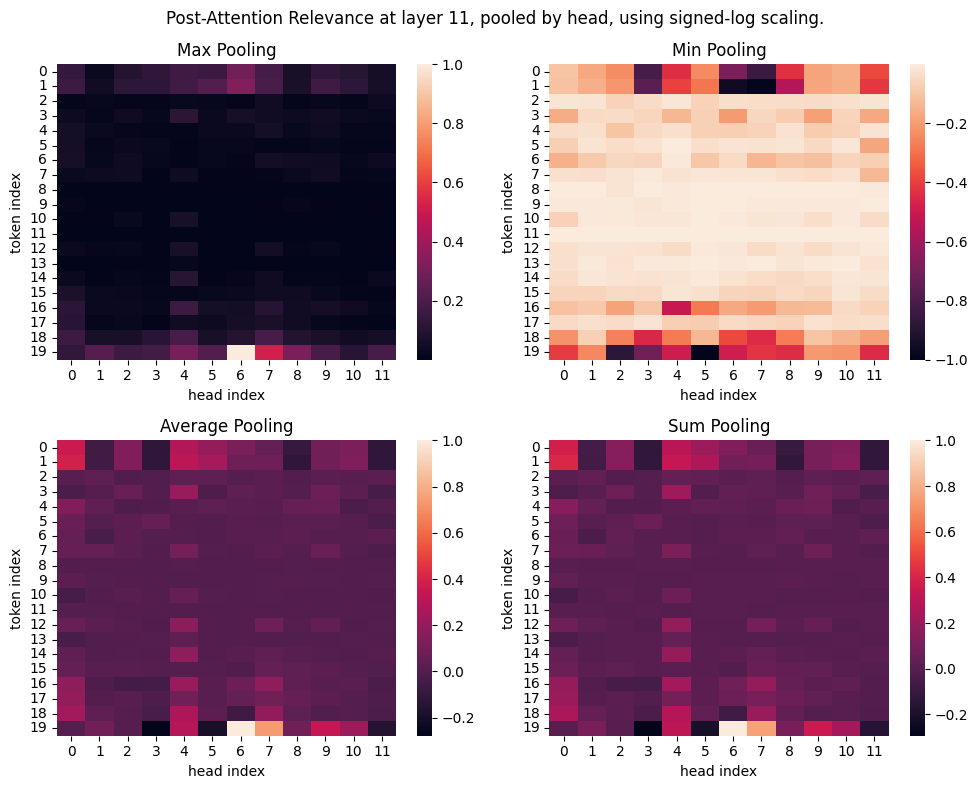

In [14]:
from util import visualize_attention_layer_relevance
visualize_attention_layer_relevance(checkpoint_vals, layer_ind=11)

## The rest of the code below is all old and not in proper scope, but can help in getting a grasp of how to debug and check certain constraints within the framework

In [14]:
# For debugging relevance paths, yes I went and looked through a graph of 700 or so nodes...

# import networkx as nx
# import matplotlib.pyplot as plt

# node_to_ind = { node : i for (i, node) in enumerate(nodes) }
# def create_graph(nodes, in_adj_list, weights, alpha = 0.5):    
#     G = nx.DiGraph()
#     G.add_nodes_from(range(len(nodes)))

#     print(node_to_ind[start], node_to_ind[end]) # Global vars, set somewhere

#     for node, in_nodes in list(in_adj_list.items()):
#         if node not in nodes:
#             continue
#         for in_node, in_weight in zip(in_nodes, input_tracker[node]):
#             if in_node not in nodes:
#                 continue
#             if isinstance(in_weight, AddBackwardPromise):
#                 if in_weight.complete:
#                     in_weight = in_weight.rin.sum()
#                 else:
#                     continue
#             elif isinstance(in_weight, torch.Tensor):
#                 in_weight = in_weight.sum()
#             G.add_edge(node_to_ind[in_node], node_to_ind[node], weight=float(in_weight))
#     return G

# def display_graph(G):
#     pos = nx.circular_layout(G)  
#     weight_labels = nx.get_edge_attributes(G, 'weight')
#     plt.figure(figsize=(50,50))
#     nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='gray', node_size=100)
#     nx.draw_networkx_edge_labels(G, pos, edge_labels=weight_labels)  
#     plt.show()

# G = create_graph(nodes, in_adj_list, input_tracker)

# print([ x for x in dir(nx) if x.endswith("layout") ])
# display_graph(G)
# print(nx.get_edge_attributes(G, 'weight'))


In [12]:
# # Check that promises maintain conservation property
# complete = list(filter(lambda p: p.complete, promises))
# for p in complete:
#     rout = p.promise["rout"].sum()
#     rin = p.promise["rins"][0].sum() + p.promise["rins"][1].sum()
#     if (rout - rin) / rout > 0.00001:
#         print(rout, rin)
        

In [ ]:
# # Checking conservation holds across the entire propagation
# # The frontier includes:
# # a) true leaf nodes (no children)
# # b) nodes which received inputs but were never traversed due to computation ending early

# frontier = [ node 
#             for node, out_nodes in list(out_adj_list.items())
#             if len(out_nodes) == 0
#            ]

# frontier += [ node for node in stack if input_tracker[node] ]

# frontier = list(set(frontier))

In [14]:
# # Tally the total relevance at the frontier
# total_frontier_in = 0.0
# for node in frontier:
#     total_in = 0.0
#     for input_ in input_tracker[node]:
#         if isinstance(input_, Promise):
#             if input_.complete:
#                 total_in += input_.rin.sum()
#             else:
#                 continue
#         elif isinstance(input_, torch.Tensor):
#             total_in += input_.sum()
#     total_frontier_in += total_in
# print(total_frontier_in)

tensor(17.0376)
